In [1]:
import numpy as np
import networkx as nx
import random
from collections import defaultdict
import collections
import matplotlib.pyplot as plt
from numpy import linalg as LA
import scipy
import pandas as pd
from scipy.interpolate import interp1d
%matplotlib inline

In [2]:
class _ListDict_(object):
    
    def __init__(self):
        self.item_to_position = {}
        self.items = []

    def __len__(self):
        return len(self.items)

    def add(self, item):
        if item in self.item_to_position:
            return
        self.items.append(item)
        self.item_to_position[item] = len(self.items)-1

    def remove(self, item):
        if item in self.item_to_position:
            position = self.item_to_position.pop(item)
            del self.items[position]
            for i in range(len(self.items)):
                if i >= position:
                    self.item_to_position[self.items[i]] = self.item_to_position[self.items[i]] - 1

    def choose_random(self):
        return random.choice(self.items)
    
    def __repr__(self):
         return repr(self.items)

    def __str__(self):
         return str(self.items)

In [3]:
def initialize_SIS_(G, initial_infecteds, infection_times, recovery_times, tmin):
    times = [tmin]
    S = [G.order()-len(initial_infecteds)]
    I = [len(initial_infecteds)]
    status = defaultdict(lambda:'S') #by default all are susceptible
    infected = list(initial_infecteds)
    infected_neighbor_count = defaultdict(lambda:0)
    risk_group = defaultdict(lambda:_ListDict_()) 
    
    for node in initial_infecteds:
        status[node] = 'I'
    for node in initial_infecteds:
        for neighbor in G.neighbors(node):
            if status[neighbor] == 'S':
                infected_neighbor_count[neighbor] += 1
                if infected_neighbor_count[neighbor] > 1:
                    risk_group[infected_neighbor_count[neighbor]-1].remove(
                                                                    neighbor)
                        
                risk_group[infected_neighbor_count[neighbor]].add(neighbor)

    return times, S, I, status, infected, infected_neighbor_count, risk_group

In [4]:
def infect(G, S, I, R, times, infected, current_time, 
                        infected_neighbor_count, risk_group, status, 
                        infection_times):
    r = random.random()*sum(n*len(risk_group[n]) for n in risk_group.keys())
    
    for n in risk_group.keys():
        r -= n*len(risk_group[n])
        if r < 0:
            break

    recipient = risk_group[n].choose_random()
    
    risk_group[n].remove(recipient)
    infected.append(recipient)
    infection_times[recipient].append(current_time)
    status[recipient] = 'I'
    S.append(S[-1] - 1)
    I.append(I[-1] + 1)
    times.append(current_time)

    for neighbor in G.neighbors(recipient):
        if status[neighbor] == 'S':
            if infected_neighbor_count[neighbor] > 0:
                risk_group[infected_neighbor_count[neighbor]].remove(neighbor)
            infected_neighbor_count[neighbor] += 1
            risk_group[infected_neighbor_count[neighbor]].add(neighbor)

In [5]:
def recover(G, S, I, times, infected, current_time, status, 
            infected_neighbor_count, risk_group, recovery_times):
    
    index = random.randint(0, I[-1] - 1)
    infected[index], infected[-1] = infected[-1], infected[index]
    recovering_node = infected.pop()

    I.append(I[-1] - 1)
    status[recovering_node] = 'S'
    S.append(S[-1] + 1)
    times.append(current_time)
    infected_neighbor_count[recovering_node] = 0
    
    for neighbor in G.neighbors(recovering_node):
        if neighbor == recovering_node:
            continue
        if status[neighbor] == 'I':
            infected_neighbor_count[recovering_node] += 1
        else:
            risk_group[infected_neighbor_count[neighbor]].remove(neighbor)
            infected_neighbor_count[neighbor] -= 1
            if infected_neighbor_count[neighbor]>0:
                risk_group[infected_neighbor_count[neighbor]].add(neighbor)
    if infected_neighbor_count[recovering_node]>0:
        risk_group[infected_neighbor_count[recovering_node]].add(recovering_node)

In [6]:
def SIS_detailed(G, tau, gamma, initial_infecteds = None, rho = None, tmin = 0, tmax = 100):

    infection_times = defaultdict(lambda: []) #defaults to an empty list 
    recovery_times = defaultdict(lambda: [])  #for each node

    tau = float(tau)  #just to avoid integer division problems.
    gamma = float(gamma)
    
    print("rho: ", rho)
    if initial_infecteds is None:
        if rho is None:
            initial_number = 1
        else:
            initial_number = int(round(G.order()*rho))
        initial_infecteds=random.sample(G.nodes(), initial_number)
    elif G.has_node(initial_infecteds):
        initial_infecteds=[initial_infecteds]
        
    times, S, I, status, infected, infected_neighbor_count, risk_group = \
                initialize_SIS_(G, initial_infecteds, infection_times,  
                                        recovery_times, tmin)
    
    print("After initialization")
    print("times: ", times)
    print("S: ", S)
    print("I: ", I)
    print("Status: ", status)
    print("infected: ", infected)

    total_trans_rate = tau*sum(n*len(risk_group[n]) for n in risk_group.keys())
    total_rec_rate = gamma*len(infected)
    total_rate = total_rec_rate + total_trans_rate
    next_time = times[-1] + random.expovariate(total_rate)
    
    while next_time < tmax and infected:
        r = random.random()*total_rate
        
        if r < total_rec_rate:
            print("recover")
            recover(G, S, I, times, infected, next_time, 
                                    status, infected_neighbor_count, 
                                    risk_group, recovery_times)
            total_rec_rate = gamma*I[-1]
        else:
            print("infection")
            infect(G, S, I, [], times, infected, next_time, 
                                infected_neighbor_count, risk_group, status, 
                                infection_times)
            #updates variables as needed and calculates new max_trans_rate
        
        print("infected: ", infected)
        
        total_trans_rate = tau*sum(n*len(risk_group[n]) 
                                    for n in risk_group.keys())
        total_rate = total_rec_rate + total_trans_rate
        if total_rate>0:
            next_time += random.expovariate(total_rate)
        else:
            next_time = float('Inf')
        

    return scipy.array(times), scipy.array(S), scipy.array(I)

In [7]:
def SIS(G, tau, gamma, initial_infecteds = None, rho = None, tmin = 0, tmax = 100):

    infection_times = defaultdict(lambda: []) #defaults to an empty list 
    recovery_times = defaultdict(lambda: [])  #for each node

    tau = float(tau)  #just to avoid integer division problems.
    gamma = float(gamma)
    
    if initial_infecteds is None:
        if rho is None:
            initial_number = 1
        else:
            initial_number = int(round(G.order()*rho))
        initial_infecteds=random.sample(G.nodes(), initial_number)
    elif G.has_node(initial_infecteds):
        initial_infecteds=[initial_infecteds]
        
    times, S, I, status, infected, infected_neighbor_count, risk_group = \
                initialize_SIS_(G, initial_infecteds, infection_times,  
                                        recovery_times, tmin)
    
    total_trans_rate = tau*sum(n*len(risk_group[n]) for n in risk_group.keys())
    total_rec_rate = gamma*len(infected)
    total_rate = total_rec_rate + total_trans_rate
    next_time = times[-1] + random.expovariate(total_rate)
    
    while next_time < tmax and infected:
        r = random.random()*total_rate
        
        if r < total_rec_rate:
            recover(G, S, I, times, infected, next_time, 
                                    status, infected_neighbor_count, 
                                    risk_group, recovery_times)
            total_rec_rate = gamma*I[-1]
        else:
            infect(G, S, I, [], times, infected, next_time, 
                                infected_neighbor_count, risk_group, status, 
                                infection_times)
            #updates variables as needed and calculates new max_trans_rate
        
        total_trans_rate = tau*sum(n*len(risk_group[n]) 
                                    for n in risk_group.keys())
        total_rate = total_rec_rate + total_trans_rate
        if total_rate>0:
            next_time += random.expovariate(total_rate)
        else:
            next_time = float('Inf')
        

    return scipy.array(times), scipy.array(S), scipy.array(I)

### Семантическая сеть

In [8]:
df = pd.read_excel('assoc_eng.xlsx')
G = nx.from_pandas_dataframe(df, 'Source', 'Target', edge_attr=None, create_using=nx.DiGraph())

In [8]:
A = nx.adjacency_matrix(G)
A = A.todense()
max_eigval = max(LA.eigvals(A))

In [9]:
max_eigval

(13.442729416193643+0j)

In [48]:
1 / max_eigval

(0.07438965473747916+0j)

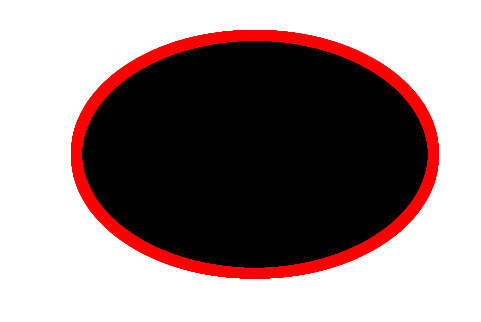

In [69]:
pos=nx.circular_layout(G)
nx.draw(G, pos, node_size = 100)#, with_labels=True)

In [8]:
G['LEG']

AtlasView({'ARM': {}, 'BODY': {}, 'BROKEN': {}, 'FOOT': {}, 'KNEE': {}, 'LONG': {}, 'MUSCLE': {}, 'RUN': {}, 'THIGH': {}, 'WALK': {}})

In [9]:
G.number_of_nodes()

5019

In [10]:
for i in G.neighbors('BAY'):
    print(i)

AREA
BOAT
FRONT
HARBOR
HORSE
LAKE
OCEAN
RIVER
SEA
SHORE
TAMPA
WATCH
WATER
WINDOW


### Анализ

In [21]:
init_infected = random.sample(set(G.nodes), 100)

#init_infected = ['COTTAGE', 'SWISS', 'CAKE']

rho:  None
After initialization
times:  [0]
S:  [5016]
I:  [3]
Status:  defaultdict(<function initialize_SIS_.<locals>.<lambda> at 0x15109a6e18>, {'COTTAGE': 'I', 'SWISS': 'I', 'CAKE': 'I', 'CABIN': 'S', 'CHEESE': 'S', 'COUNTRY': 'S', 'HOME': 'S', 'HOUSE': 'S', 'HUT': 'S', 'LAKE': 'S', 'SMALL': 'S', 'WOODS': 'S', 'ACCOUNT': 'S', 'ARMY': 'S', 'BANK': 'S', 'CHEDDAR': 'S', 'CHOCOLATE': 'S', 'KNIFE': 'S', 'SKI': 'S', 'WATCH': 'S', 'BAKE': 'S', 'BIRTHDAY': 'S', 'COOKIE': 'S', 'CREAM': 'S', 'DIET': 'S', 'EAT': 'S', 'FAT': 'S', 'FOOD': 'S', 'FROSTING': 'S', 'GOOD': 'S', 'ICE CREAM': 'S', 'ICING': 'S', 'MIX': 'S', 'PARTY': 'S', 'PIE': 'S', 'SWEET': 'S', 'WALK': 'S', 'YUMMY': 'S'})
infected:  ['COTTAGE', 'SWISS', 'CAKE']
recover
infected:  ['CAKE', 'SWISS']
infection
infected:  ['CAKE', 'SWISS', 'ARMY']
infection
infected:  ['CAKE', 'SWISS', 'ARMY', 'FAT']
infection
infected:  ['CAKE', 'SWISS', 'ARMY', 'FAT', 'SLOB']
recover
infected:  ['SLOB', 'SWISS', 'ARMY', 'FAT']
infection
infected:  ['SLO

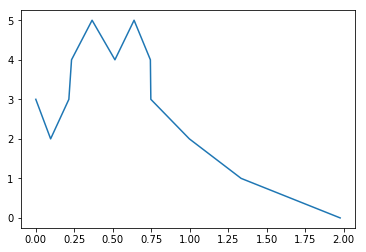

In [21]:
initial_size = 3
gamma = 1.
tau = 0.05
t, S, I = SIS_detailed(G, tau, gamma, tmax = 20,
                        initial_infecteds = init_infected)

plt.plot(t, I)

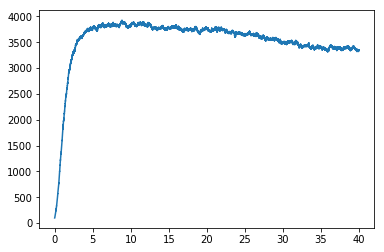

In [34]:
initial_size = 100
init_infected = random.sample(set(G.nodes), 100)
gamma = 1.
tau = 0.5
t, S, I = SIS(G, tau, gamma, tmax = 40, initial_infecteds = init_infected)

plt.plot(t, I)

In [27]:
def get_stability_time(inf_arr, num_steps, interval, eps, threshold):
    count = 0
    stab_time = num_steps
    for i, j in zip(np.arange(0, num_steps - interval, 1), np.arange(interval, num_steps, 1)):
        if abs(inf_arr[j] - inf_arr[i]) < eps:
            count += 1
        else:
            count = 0
        if count > threshold:
            stab_time = i
            break
    return stab_time        

## Ансамбль из 100 сетей изначально зараженных вершин

In [28]:
G = nx.from_pandas_dataframe(df, 'Source', 'Target', edge_attr=None, create_using=nx.DiGraph())
num_init_infected = 100
init_inf = random.sample(set(G.nodes), num_init_infected)

In [24]:
p_inf_arr = np.linspace(0.01, 0.2, 10)
p_inf_arr

array([0.01      , 0.03111111, 0.05222222, 0.07333333, 0.09444444,
       0.11555556, 0.13666667, 0.15777778, 0.17888889, 0.2       ])

In [31]:
initial_size = 100
gamma = 1.
t_stab = []
std_array = []
for prob in p_inf_arr:
    print("--------------------------------")
    print("infection probability: ", prob)
    
    inf_array = []
    for i in range(100):
        t, S, I = SIS(G, prob, gamma, tmax = 20, initial_infecteds = init_inf)
        inf_array.append(I.tolist())
        
    #bug-fix: заполняем последними значениями списки зараженных для единообразия
    max_len = max([len(arr) for arr in inf_array])
    for arr in inf_array:
        if len(arr) < max_len:
            last_elem = arr[-1]
            for j in range(max_len - len(arr)):
                arr.append(last_elem)
    
    ens_inf = np.stack((inf_array), axis = -1)
    std_inf = [np.std(lst) for lst in ens_inf]
    avrg_inf = [np.mean(lst) for lst in ens_inf]
    stab_time = get_stability_time(avrg_inf, len(t), 100, 0.1, 5)
    
    std_array.append(std_inf[stab_time - 1])
    t_stab.append(t[stab_time - 1])

--------------------------------
infection probability:  0.01
--------------------------------
infection probability:  0.03111111111111111
--------------------------------
infection probability:  0.052222222222222225
--------------------------------
infection probability:  0.07333333333333333
--------------------------------
infection probability:  0.09444444444444444
--------------------------------
infection probability:  0.11555555555555555
--------------------------------
infection probability:  0.1366666666666667
--------------------------------
infection probability:  0.1577777777777778
--------------------------------
infection probability:  0.1788888888888889
--------------------------------
infection probability:  0.2


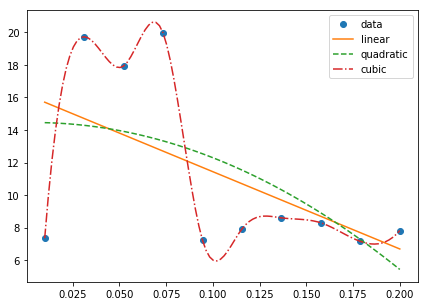

In [47]:
z = np.polyfit(p_inf_arr, t_stab, 1)
p = np.poly1d(z)
p30 = np.poly1d(np.polyfit(p_inf_arr, t_stab, 2))
f1 = interp1d(p_inf_arr, t_stab, kind='cubic')
xp = np.linspace(0.01, 0.2, 100)

f = plt.figure(figsize=(7,5))
plt.plot(p_inf_arr, t_stab, 'o', xp, p(xp), '-', xp, p30(xp), '--', xp, f1(xp), '-.')
plt.legend(['data', 'linear', 'quadratic', 'cubic'], loc='best')
plt.show()

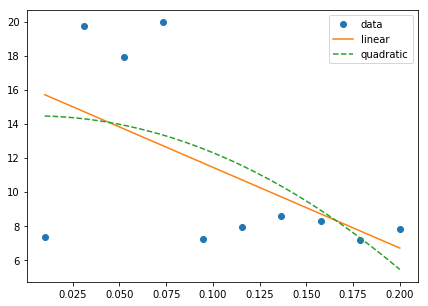

In [48]:
z = np.polyfit(p_inf_arr, t_stab, 1)
p = np.poly1d(z)
p30 = np.poly1d(np.polyfit(p_inf_arr, t_stab, 2))
f1 = interp1d(p_inf_arr, t_stab, kind='cubic')
xp = np.linspace(0.01, 0.2, 100)

f = plt.figure(figsize=(7,5))
plt.plot(p_inf_arr, t_stab, 'o', xp, p(xp), '-', xp, p30(xp), '--')#, xp, f1(xp), '-.')
plt.legend(['data', 'linear', 'quadratic', 'cubic'], loc='best')
plt.show()

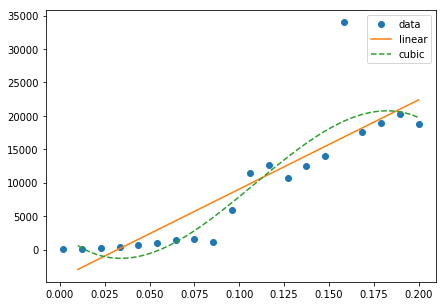

In [69]:
z = np.polyfit(p_inf_arr, t_stab, 1)
p = np.poly1d(z)
p30 = np.poly1d(np.polyfit(p_inf_arr, t_stab, 3))
f1 = interp1d(p_inf_arr, t_stab, kind='cubic')
xp = np.linspace(0.01, 0.2, 100)

f = plt.figure(figsize=(7,5))
plt.plot(p_inf_arr, t_stab, 'o', xp, p(xp), '-', xp, p30(xp), '--')#, xp, f1(xp), '-.')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

In [89]:
f1 = interp1d(p_inf_arr, t_stab)
f2 = interp1d(p_inf_arr, t_stab, kind='cubic')

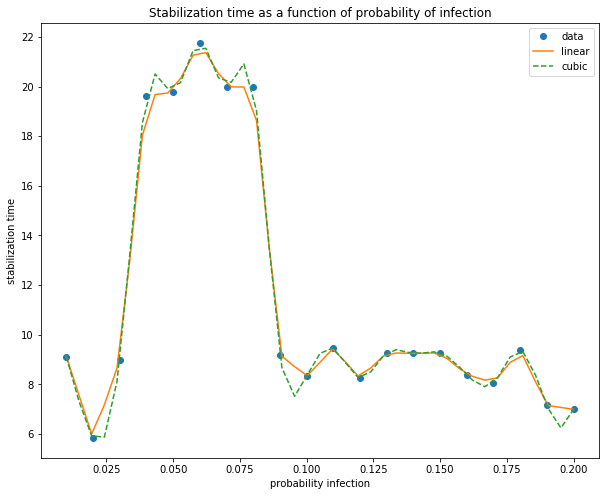

In [94]:
f = plt.figure(figsize=(10,8))
xnew = np.linspace(0.01, 0.2, num=41, endpoint=True)
plt.title('Stabilization time as a function of probability of infection')
plt.xlabel('probability infection')
plt.ylabel('stabilization time')
plt.plot(p_inf_arr, t_stab, 'o', xnew, f1(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

In [91]:
std_array

[3.6252448193191036,
 6.771587701566007,
 3.4942667328067554,
 5.636266494764066,
 11.062205928294771,
 8.596621429375613,
 11.418734605900953,
 18.371529604254512,
 36.85541479891388,
 45.1619485850644,
 75.37400082256481,
 68.75841766649376,
 207.3791802471984,
 70.47748860451826,
 69.80561295483338,
 53.18232413123744,
 52.180528935609686,
 67.2608533992842,
 49.209019498461856,
 47.5077425268766]

Text(0.5,1,'SIS model on semantic network (ensemble)')

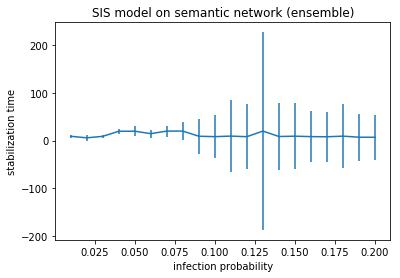

In [55]:
f = plt.figure()
plt.errorbar(p_inf_arr, t_stab, std_array)
plt.xlabel('infection probability')
plt.ylabel('stabilization time')
plt.title('SIS model on semantic network (ensemble)')

In [51]:
p_inf_arr = np.linspace(0.002, 0.2, 20)

initial_size = 100
gamma = 1.
t_stab = []
t_arr = []
inf_frac = []
std_arr = []
for prob in p_inf_arr:
    print("--------------------------------")
    print("infection probability: ", prob)
    
    inf_array = []
    t_array = []
    for i in range(100):
        t, S, I = SIS(G, prob, gamma, tmax = 20, initial_infecteds = init_inf)
        inf_array.append(I.tolist())
        t_array.append(t.tolist())
    
    #bug-fix: заполняем последними значениями списки зараженных для единообразия
    max_len_inf = max([len(arr) for arr in inf_array])
    for arr in inf_array:
        if len(arr) < max_len_inf:
            last_elem = arr[-1]
            for j in range(max_len_inf - len(arr)):
                arr.append(last_elem)
    
    #возьмем время с максимальной длиной
    t_max_len = [len(arr) for arr in t_array].index(max([len(arr) for arr in t_array]))
    t_arr.append(t_array[t_max_len])
        
    ens_inf = np.stack((inf_array), axis=-1)
    avrg_inf = [np.mean(lst) for lst in ens_inf]
    std = [np.std(lst) for lst in ens_inf]
    stab_time = get_stability_time(avrg_inf, len(t), 100, 0.1, 5)

    t_stab.append(stab_time)
    inf_frac.append(avrg_inf)
    std_arr.append(std)

--------------------------------
infection probability:  0.002
--------------------------------
infection probability:  0.012421052631578947
--------------------------------
infection probability:  0.022842105263157893
--------------------------------
infection probability:  0.03326315789473684
--------------------------------
infection probability:  0.04368421052631579
--------------------------------
infection probability:  0.05410526315789474
--------------------------------
infection probability:  0.06452631578947368
--------------------------------
infection probability:  0.07494736842105264
--------------------------------
infection probability:  0.08536842105263158
--------------------------------
infection probability:  0.09578947368421052
--------------------------------
infection probability:  0.10621052631578948
--------------------------------
infection probability:  0.11663157894736842
--------------------------------
infection probability:  0.12705263157894736
-----------

In [52]:
frac_arr = []
std_at_stab_time = []
for i, arr in enumerate(inf_frac):
    frac_arr.append(arr[t_stab[i]])
    std_at_stab_time.append(std[t_stab[i]])

Text(0,0.5,'number of infected')

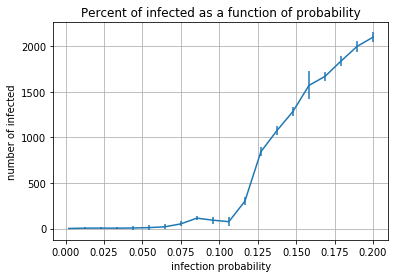

In [65]:
fig, ax = plt.subplots()
ax.errorbar(p_inf_arr, frac_arr, yerr = std_at_stab_time)
ax.grid(True)
ax.set_title('Percent of infected as a function of probability')
ax.set_xlabel('infection probability')
ax.set_ylabel('number of infected')

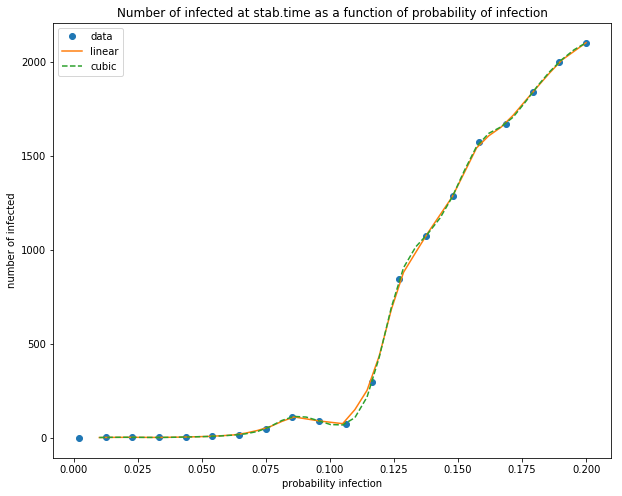

In [64]:
f1 = interp1d(p_inf_arr, frac_arr)
f2 = interp1d(p_inf_arr, frac_arr, kind='cubic')

f = plt.figure(figsize=(10,8))
xnew = np.linspace(0.01, 0.2, num=41, endpoint=True)
plt.title('Number of infected at stab.time as a function of probability of infection')
plt.xlabel('probability infection')
plt.ylabel('number of infected')
plt.plot(p_inf_arr, frac_arr, 'o', xnew, f1(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

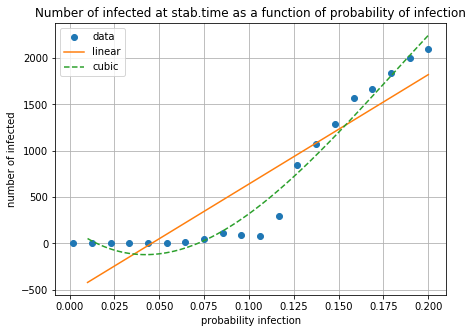

In [68]:
z = np.polyfit(p_inf_arr, frac_arr, 1)
p = np.poly1d(z)
p30 = np.poly1d(np.polyfit(p_inf_arr, frac_arr, 3))
f1 = interp1d(p_inf_arr, frac_arr, kind='cubic')
xp = np.linspace(0.01, 0.2, 100)

f = plt.figure(figsize=(7,5))
plt.plot(p_inf_arr, frac_arr, 'o', xp, p(xp), '-', xp, p30(xp), '--')#, xp, f1(xp), '-.')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.grid(True)
plt.title('Number of infected at stab.time as a function of probability of infection')
plt.xlabel('probability infection')
plt.ylabel('number of infected')
plt.show()

In [71]:
tau_arr = np.linspace(0.001, 0.2, 10)
tau_arr

array([0.001     , 0.02311111, 0.04522222, 0.06733333, 0.08944444,
       0.11155556, 0.13366667, 0.15577778, 0.17788889, 0.2       ])

In [72]:
initial_size = 100
gamma = 1.
tau = 0.004
init_inf = random.sample(set(G.nodes), initial_size)
I_arr, t_arr = [], []
for tau in tau_arr:
#for tau in [0.13]:
    print(tau)
    sub_t, sub_I = [], []
    for i in range(100):
        t, S, I = SIS(G, tau, gamma, tmax = 30,
                        initial_infecteds = init_inf)
        sub_t.append(t.tolist())
        sub_I.append(I.tolist())
    
    max_len_I = max([len(arr) for arr in sub_I])
    for arr_i in sub_I:
        if len(arr_i) < max_len_I:
            last_elem = arr_i[-1]
            for j in range(max_len_I - len(arr_i)):
                arr_i.append(last_elem)
                
    ens_I = np.stack((sub_I), axis = -1)
    avrg_I = [np.mean(lst) for lst in ens_I]
    
    I_arr.append(avrg_I)
    t_arr.append(max(sub_t, key=len)) #max time

0.001
0.023111111111111114
0.045222222222222226
0.06733333333333334
0.08944444444444445
0.11155555555555556
0.13366666666666668
0.1557777777777778
0.1778888888888889
0.2


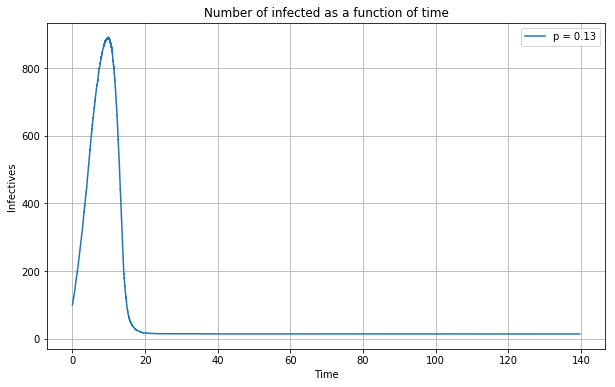

In [767]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t_arr[0], I_arr[0], label= "p = 0.13")

ax.legend(loc='upper right')
ax.grid(True)
ax.set_title('Number of infected as a function of time')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

In [573]:
initial_size = 100
gamma = 1.
tau = 0.004
init_inf = random.sample(set(G.nodes), initial_size)
I_arr, t_arr = [], []
for tau in (tau_arr):
    print(tau)
    t, S, I = SIS(G, tau, gamma, tmax = 150,
                        initial_infecteds = init_inf)
    I_arr.append(I)
    t_arr.append(t)

0.001
0.023111111111111114
0.045222222222222226
0.06733333333333334
0.08944444444444445
0.11155555555555556
0.13366666666666668
0.1557777777777778
0.1778888888888889
0.2


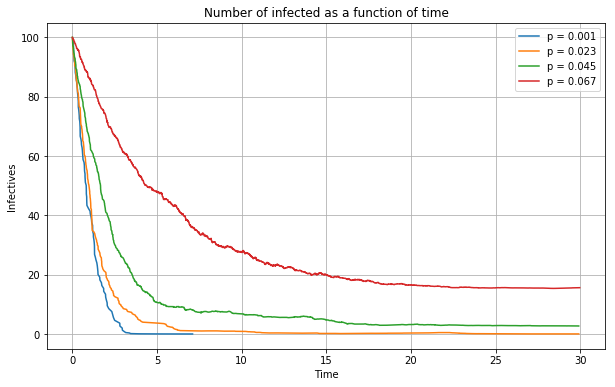

In [73]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t_arr[0], I_arr[0], label= "p = " + str(round(tau_arr[0], 3)))

ax.plot(t_arr[1], I_arr[1], label= "p = " + str(round(tau_arr[1], 3)))

ax.plot(t_arr[2], I_arr[2], label= "p = " + str(round(tau_arr[2], 3)))

ax.plot(t_arr[3], I_arr[3], label= "p = " + str(round(tau_arr[3], 3)))

ax.legend(loc='upper right')
ax.grid(True)
ax.set_title('Number of infected as a function of time')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

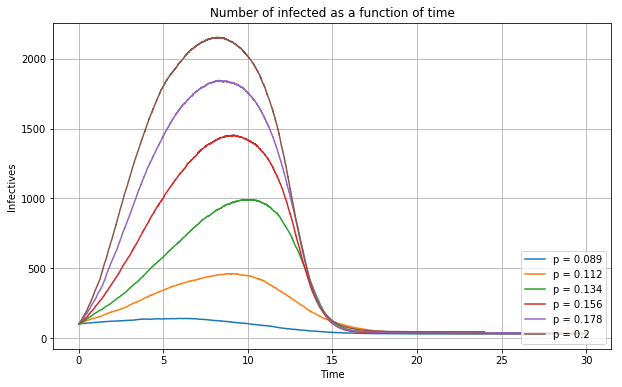

In [74]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(t_arr[4], I_arr[4], label= "p = " + str(round(tau_arr[4], 3)))

ax.plot(t_arr[5], I_arr[5], label= "p = " + str(round(tau_arr[5], 3)))

ax.plot(t_arr[6], I_arr[6], label= "p = " + str(round(tau_arr[6], 3)))

ax.plot(t_arr[7], I_arr[7], label= "p = " + str(round(tau_arr[7], 3)))

ax.plot(t_arr[8], I_arr[8], label= "p = " + str(round(tau_arr[8], 3)))

ax.plot(t_arr[9], I_arr[9], label= "p = " + str(round(tau_arr[9], 3)))

ax.legend(loc='lower right')
ax.grid(True)
ax.set_title('Number of infected as a function of time')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

In [145]:
initial_size = 500
gamma = 1.
init_inf = random.sample(set(G.nodes), initial_size)
I_arr, t_arr = [], []
for tau in (tau_arr):
    print(tau)
    t, S, I = SIS(G, tau, gamma, tmax = 40,
                        initial_infecteds = init_inf)
    I_arr.append(I)
    t_arr.append(t)

0.001
0.023111111111111114
0.045222222222222226
0.06733333333333334
0.08944444444444445
0.11155555555555556
0.13366666666666668
0.1557777777777778
0.1778888888888889
0.2


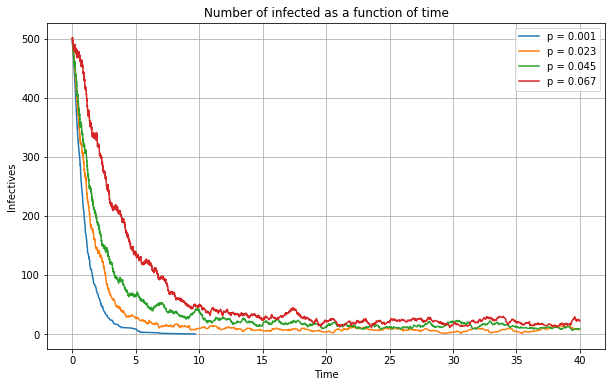

In [146]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t_arr[0], I_arr[0], label= "p = " + str(round(tau_arr[0], 3)))

ax.plot(t_arr[1], I_arr[1], label= "p = " + str(round(tau_arr[1], 3)))

ax.plot(t_arr[2], I_arr[2], label= "p = " + str(round(tau_arr[2], 3)))

ax.plot(t_arr[3], I_arr[3], label= "p = " + str(round(tau_arr[3], 3)))

ax.legend(loc='upper right')
ax.grid(True)
ax.set_title('Number of infected as a function of time')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

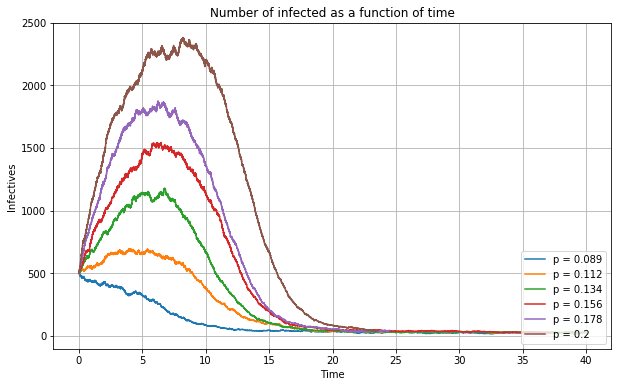

In [147]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(t_arr[4], I_arr[4], label= "p = " + str(round(tau_arr[4], 3)))

ax.plot(t_arr[5], I_arr[5], label= "p = " + str(round(tau_arr[5], 3)))

ax.plot(t_arr[6], I_arr[6], label= "p = " + str(round(tau_arr[6], 3)))

ax.plot(t_arr[7], I_arr[7], label= "p = " + str(round(tau_arr[7], 3)))

ax.plot(t_arr[8], I_arr[8], label= "p = " + str(round(tau_arr[8], 3)))

ax.plot(t_arr[9], I_arr[9], label= "p = " + str(round(tau_arr[9], 3)))

ax.legend(loc='lower right')
ax.grid(True)
ax.set_title('Number of infected as a function of time')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

In [76]:
initial_size = 100
gamma = 1.
I_arr, t_arr = [], []
tau_arr = np.linspace(0.005, 0.08, 10)
for tau in (tau_arr):
    I_tmp = []
    t_tmp = []
    for init_inf in init_infected_ensemble:
        t, S, I = SIS(G, tau, gamma, tmax = 20, initial_infecteds = init_inf)
        I_tmp.append(I.tolist())
        t_tmp.append(t.tolist())
    
    #дозаполним число зараженных, преобразуем в усредненный список
    max_len_inf = max([len(arr) for arr in I_tmp])
    for arr in I_tmp:
        if len(arr) < max_len_inf:
            last_elem = arr[-1]
            for j in range(max_len_inf - len(arr)):
                arr.append(last_elem)
    ens_inf = np.stack((I_tmp), axis=-1)
    avrg_inf = [np.mean(lst) for lst in ens_inf]
    I_arr.append(avrg_inf)
    
    #возьмем время с максимальной длиной
    t_max_len = [len(arr) for arr in t_tmp].index(max([len(arr) for arr in t_tmp]))
    t_arr.append(t_tmp[t_max_len])

In [77]:
tau_arr

array([0.005     , 0.01333333, 0.02166667, 0.03      , 0.03833333,
       0.04666667, 0.055     , 0.06333333, 0.07166667, 0.08      ])

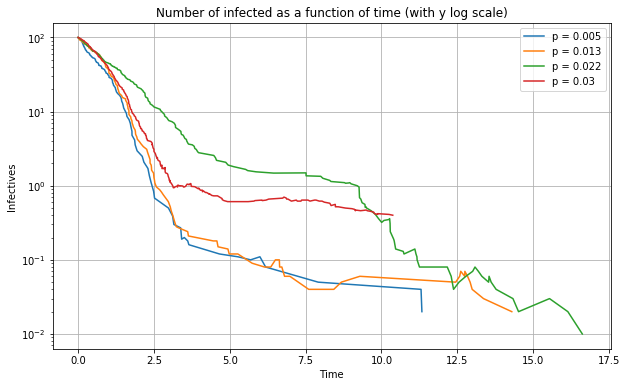

In [81]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_yscale('log')

ax.plot(t_arr[0], I_arr[0], label='p = ' + str(round(tau_arr[0], 3)))

ax.plot(t_arr[1], I_arr[1], label='p = ' + str(round(tau_arr[1], 3)))

ax.plot(t_arr[2], I_arr[2], label='p = ' + str(round(tau_arr[2], 3)))

ax.plot(t_arr[3], I_arr[3], label='p = ' + str(round(tau_arr[3], 3)))

ax.legend(loc='upper right')
ax.grid(True)
ax.set_title('Number of infected as a function of time (with y log scale)')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

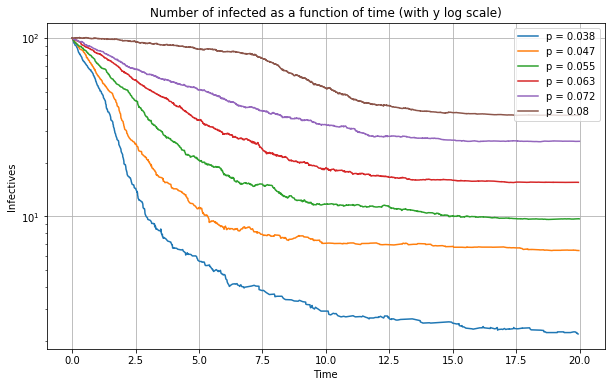

In [83]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_yscale('log')

ax.plot(t_arr[4], I_arr[4], label='p = ' + str(round(tau_arr[4], 3)))

ax.plot(t_arr[5], I_arr[5], label='p = ' + str(round(tau_arr[5], 3)))

ax.plot(t_arr[6], I_arr[6], label='p = ' + str(round(tau_arr[6], 3)))

ax.plot(t_arr[7], I_arr[7], label='p = ' + str(round(tau_arr[7], 3)))

ax.plot(t_arr[8], I_arr[8], label='p = ' + str(round(tau_arr[8], 3)))

ax.plot(t_arr[9], I_arr[9], label='p = ' + str(round(tau_arr[9], 3)))

ax.legend(loc='upper right')
ax.grid(True)
ax.set_title('Number of infected as a function of time (with y log scale)')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

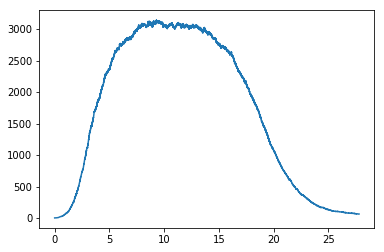

In [151]:
initial_size = 3
gamma = 1.
tau = 0.3
init_infected = random.sample(set(G.nodes), initial_size)
t, S, I = SIS(G, tau, gamma, tmax = 150, initial_infecteds = init_infected)

plt.plot(t, I)

Исследуем вероятность нахождения ответа

In [75]:
data = pd.read_excel("dataTR.xlsx")
data.head()

,Word1,Word2,Word3,Answer,Complexity
0,COTTAGE,SWISS,CAKE,CHEESE,0
1,CREAM,SKATE,WATER,ICE,0
2,LOSER,THROAT,SPOT,SORE,0
3,SHOW,LIFE,ROW,BOAT,0
4,NIGHT,WRIST,STOP,WATCH,0


In [380]:
data.loc[1][0]

'CREAM'

Сколько шагов надо сделать чтобы дойти до ответа?

In [76]:
def infect_with_infected(G, S, I, R, times, infected, current_time, 
                        infected_neighbor_count, risk_group, status, 
                        infection_times):
    r = random.random()*sum(n*len(risk_group[n]) for n in risk_group.keys())
    
    for n in risk_group.keys():
        r -= n*len(risk_group[n])
        if r < 0:
            break

    recipient = risk_group[n].choose_random()
    
    risk_group[n].remove(recipient)
    infected.append(recipient)
    infection_times[recipient].append(current_time)
    status[recipient] = 'I'
    S.append(S[-1] - 1)
    I.append(I[-1] + 1)
    times.append(current_time)

    for neighbor in G.neighbors(recipient):
        if status[neighbor] == 'S':
            if infected_neighbor_count[neighbor] > 0:
                risk_group[infected_neighbor_count[neighbor]].remove(neighbor)
            infected_neighbor_count[neighbor] += 1
            risk_group[infected_neighbor_count[neighbor]].add(neighbor)
    return infected

In [77]:
def recover_with_infected(G, S, I, times, infected, current_time, status, 
            infected_neighbor_count, risk_group, recovery_times):
    
    index = random.randint(0, I[-1] - 1)
    infected[index], infected[-1] = infected[-1], infected[index]
    recovering_node = infected.pop()

    I.append(I[-1] - 1)
    status[recovering_node] = 'S'
    S.append(S[-1] + 1)
    times.append(current_time)
    infected_neighbor_count[recovering_node] = 0
    
    for neighbor in G.neighbors(recovering_node):
        if neighbor == recovering_node:
            continue
        if status[neighbor] == 'I':
            infected_neighbor_count[recovering_node] += 1
        else:
            risk_group[infected_neighbor_count[neighbor]].remove(neighbor)
            infected_neighbor_count[neighbor] -= 1
            if infected_neighbor_count[neighbor]>0:
                risk_group[infected_neighbor_count[neighbor]].add(neighbor)
    if infected_neighbor_count[recovering_node]>0:
        risk_group[infected_neighbor_count[recovering_node]].add(recovering_node)
    return infected

In [78]:
def SIS_with_infected(G, tau, gamma, initial_infecteds = None, rho = None, tmin = 0, tmax = 100, answer = None):

    infection_times = defaultdict(lambda: [])
    recovery_times = defaultdict(lambda: [])

    tau = float(tau)
    gamma = float(gamma)
    
    if initial_infecteds is None:
        if rho is None:
            initial_number = 1
        else:
            initial_number = int(round(G.order()*rho))
        initial_infecteds=random.sample(G.nodes(), initial_number)
    elif G.has_node(initial_infecteds):
        initial_infecteds=[initial_infecteds]
        
    times, S, I, status, infected, infected_neighbor_count, risk_group = \
                initialize_SIS_(G, initial_infecteds, infection_times,  
                                        recovery_times, tmin)
    
    total_trans_rate = tau*sum(n*len(risk_group[n]) for n in risk_group.keys())
    total_rec_rate = gamma*len(infected)
    total_rate = total_rec_rate + total_trans_rate
    next_time = times[-1] + 0.01
    
    inf_array = []
    inf_array.append(infected[:])
    
    while next_time < tmax and infected:
        r = random.random()*total_rate
        
        if r < total_rec_rate:
            recover_with_infected(G, S, I, times, infected, next_time, 
                                    status, infected_neighbor_count, 
                                    risk_group, recovery_times)
            total_rec_rate = gamma*I[-1]
        else:
            infect_with_infected(G, S, I, [], times, infected, next_time, 
                                infected_neighbor_count, risk_group, status, 
                                infection_times)
        
        total_trans_rate = tau*sum(n*len(risk_group[n]) 
                                    for n in risk_group.keys())
        total_rate = total_rec_rate + total_trans_rate
        next_time += 0.01
        
        inf_array.append(infected[:])
        

    return scipy.array(times), scipy.array(S), scipy.array(I), inf_array

['COTTAGE', 'SWISS', 'CAKE']
['COTTAGE', 'SWISS', 'CAKE', 'SWEET']
['COTTAGE', 'SWISS', 'CAKE', 'SWEET', 'SOUR']
['SOUR', 'SWISS', 'CAKE', 'SWEET']
['SOUR', 'SWISS', 'CAKE', 'SWEET', 'CANDY']
['SOUR', 'SWISS', 'CANDY', 'SWEET']
['SOUR', 'SWISS', 'CANDY', 'SWEET', 'BAD']
['SOUR', 'SWISS', 'BAD', 'SWEET']
['SOUR', 'SWISS', 'BAD']
['SOUR', 'BAD']
['SOUR', 'BAD', 'GIRL']
['SOUR', 'BAD']
['SOUR']
[]


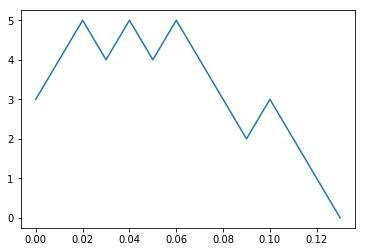

In [123]:
init_inf = [data.loc[0][0], data.loc[0][1], data.loc[0][2]]
gamma = 1.
tau = 0.05
t, S, I, inf_array = SIS_with_infected(G, tau, gamma, tmax = 20, initial_infecteds = init_inf, answer = data.loc[0][3])
for i in inf_array:
    print(i)
plt.plot(t, I)

In [142]:
inf_set = set([item for sublist in inf_array for item in sublist])

In [169]:
inf_array

[['COTTAGE', 'SWISS', 'CAKE'],
 ['COTTAGE', 'SWISS', 'CAKE', 'SWEET'],
 ['COTTAGE', 'SWISS', 'CAKE', 'SWEET', 'SOUR'],
 ['SOUR', 'SWISS', 'CAKE', 'SWEET'],
 ['SOUR', 'SWISS', 'CAKE', 'SWEET', 'CANDY'],
 ['SOUR', 'SWISS', 'CANDY', 'SWEET'],
 ['SOUR', 'SWISS', 'CANDY', 'SWEET', 'BAD'],
 ['SOUR', 'SWISS', 'BAD', 'SWEET'],
 ['SOUR', 'SWISS', 'BAD'],
 ['SOUR', 'BAD'],
 ['SOUR', 'BAD', 'GIRL'],
 ['SOUR', 'BAD'],
 ['SOUR'],
 []]

In [279]:
inf_set_with_neighbors = set()
for i in range(len(list(inf_set))):
    for word in G.neighbors(list(inf_set)[i]):
        print(word)
        inf_set_with_neighbors.add(word)
    print("---------")

BOY
FEMALE
FRIEND
GUY
INNOCENCE
LADY
PRETTY
WOMAN
---------
BAD
BITTER
CANDY
CREAM
DOUGH
GRAPE
LEMON
MILK
SALT
SWEET
TART
TASTE
---------
BAKE
BIRTHDAY
CHOCOLATE
COOKIE
CREAM
DIET
EAT
FAT
FOOD
FROSTING
GOOD
ICE CREAM
ICING
MIX
PARTY
PIE
SWEET
WALK
YUMMY
---------
APPLE
BABY
BAR
CALORIES
CANE
CHILD
CHOCOLATE
FATTENING
GOOD
GUM
JUNK
STORE
SUGAR
SWEET
---------
BOY
BREATH
COMPANY
CRIME
DOG
GIRL
GOOD
NEWS
TEMPER
---------
BITTER
CANDY
CHOCOLATE
GOOD
KIND
MEAN
NICE
POTATO
SOUR
SUGAR
TASTE
TOOTH
---------
ACCOUNT
ARMY
BANK
CHEDDAR
CHEESE
CHOCOLATE
KNIFE
SKI
WATCH
---------
CABIN
CHEESE
COUNTRY
HOME
HOUSE
HUT
LAKE
SMALL
WOODS
---------


In [276]:
inf_set

{'BAD', 'CAKE', 'CANDY', 'COTTAGE', 'GIRL', 'SOUR', 'SWEET', 'SWISS'}

In [264]:
H = G.subgraph(list(inf_set_with_neighbors))

(-0.10345983456238173,
 1.1015848769794683,
 -0.07438396211713552,
 1.0961869276687501)

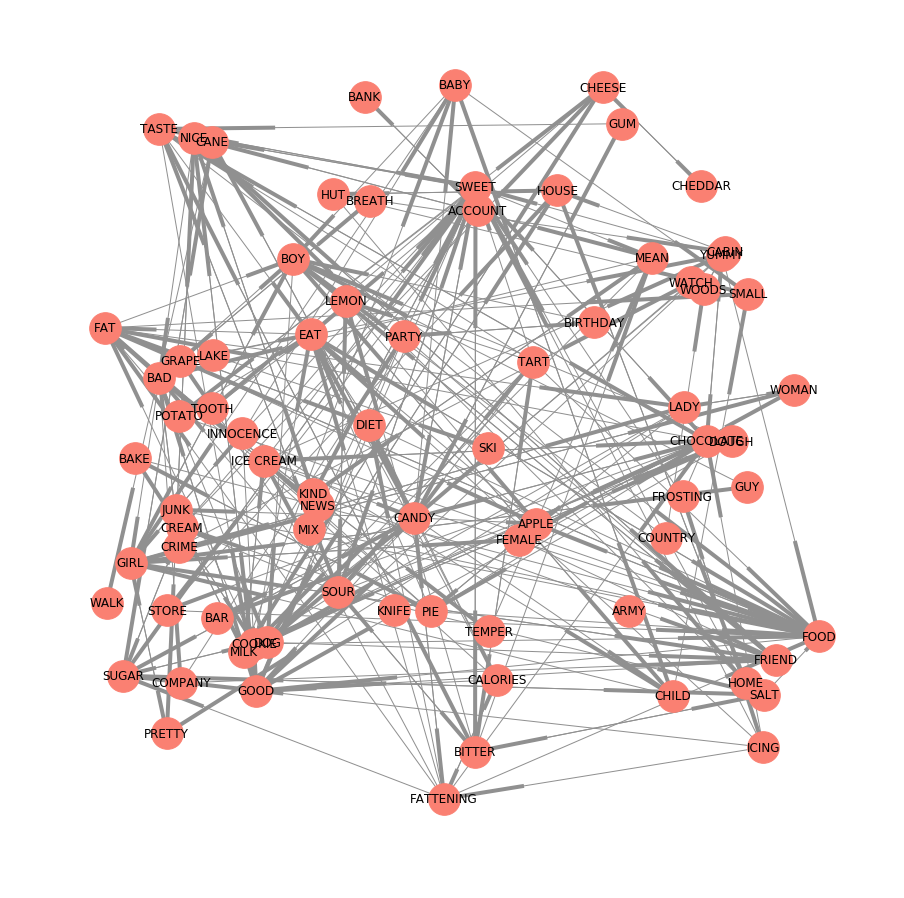

In [283]:
GG=nx.DiGraph()
H = G.subgraph(list(inf_set_with_neighbors))
GG.add_nodes_from(H.nodes)
GG.add_edges_from(H.edges)

labels = {}
for node in H.nodes():
    labels[node] = node
plt.figure(1, figsize=(12,12))
nx.draw_random(GG, node_color='salmon', edge_color='#909090', node_size=1000, labels=labels)

plt.axis('off')

(-1.2099999418216294,
 1.2099999944717386,
 -1.1619134058388503,
 1.1923681220003677)

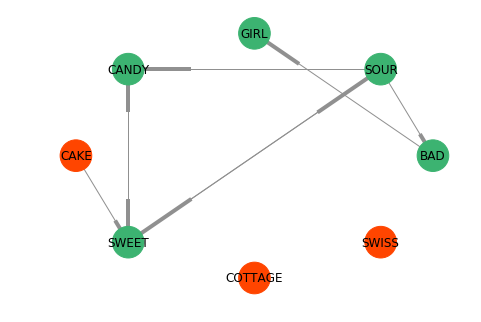

In [308]:
GG=nx.DiGraph()
H = G.subgraph(list(inf_set))
GG.add_nodes_from(H.nodes)
GG.add_edges_from(H.edges)

labels = {}
for node in H.nodes():
    labels[node] = node
plt.figure(1, figsize=(6,4))

color_map = []
for node in GG:
    if node in inf_array[0]:
        color_map.append('orangered')
    else: color_map.append('mediumseagreen') 
        
nx.draw_circular(GG, node_color=color_map, edge_color='#909090', node_size=1000, labels=labels)

plt.axis('off')

### Гипотеза 1:
Время решения теста прямо пропорционально сложности теста

['COTTAGE', 'SWISS', 'CAKE']
['COTTAGE', 'SWISS', 'CAKE', 'SMALL']
['COTTAGE', 'SWISS', 'CAKE', 'SMALL', 'ICE CREAM']
['COTTAGE', 'SWISS', 'CAKE', 'ICE CREAM']
['COTTAGE', 'SWISS', 'CAKE']
['CAKE', 'SWISS']
['CAKE', 'SWISS', 'ICING']
['CAKE', 'SWISS']
['SWISS']
[]


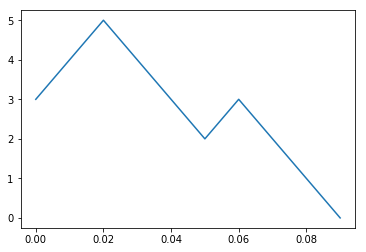

In [21]:
init_inf = [data.loc[0][0], data.loc[0][1], data.loc[0][2]]
gamma = 1.
tau = 0.05
t, S, I, inf_array = SIS_with_infected(G, tau, gamma, tmax = 20, initial_infecteds = init_inf, answer = data.loc[0][3])
for i in inf_array:
    print(i)
plt.plot(t, I)

In [88]:
def get_complexity(infected_array, answer):
    num = 0
    for i, arr in enumerate(infected_array):
        if answer in arr:
            num = i
            break
    return num

In [89]:
def get_time_answer(G, tau, gamma, init_inf, answer):
    t, S, I, inf_array = SIS_with_infected(G, tau, gamma, tmax = 20, initial_infecteds = init_inf, answer = answer)

    time_compl = get_complexity(inf_array, answer)
    return time_compl

In [125]:
compl_light_arr = []
compl_medium_arr = []
compl_hard_arr = []

tau = 0.06
gamma = 1.

for i in range(len(data)):
    init_inf = [data.loc[i][0], data.loc[i][1], data.loc[i][2]]
    answer = data.loc[i][3]
    print(init_inf)
    if data.loc[i]['Complexity'] == 0:
        tmp = []
        for j in range(100):
            tmp.append(get_time_answer(G, tau, gamma, init_inf, answer))
        compl_light_arr.append(np.mean(tmp))
    elif data.loc[i]['Complexity'] == 1:
        tmp = []
        for j in range(100):
            tmp.append(get_time_answer(G, tau, gamma, init_inf, answer))
        compl_medium_arr.append(np.mean(tmp))
    elif data.loc[i]['Complexity'] == 2:
        tmp = []
        for j in range(100):
            tmp.append(get_time_answer(G, tau, gamma, init_inf, answer))
        compl_hard_arr.append(np.mean(tmp))
            
print("Light: ", np.mean(compl_light_arr))
print("Medium: ", np.mean(compl_medium_arr))
print("Hard: ", np.mean(compl_hard_arr))

['COTTAGE', 'SWISS', 'CAKE']
['CREAM', 'SKATE', 'WATER']
['LOSER', 'THROAT', 'SPOT']
['SHOW', 'LIFE', 'ROW']
['NIGHT', 'WRIST', 'STOP']
['DUCK', 'FOLD', 'DOLLAR']
['DEW', 'COMB', 'BEE']
['AID', 'RUBBER', 'WAGON']
['CRACKER', 'FLY', 'FIGHTER']
['SAFETY', 'CUSHION', 'POINT']
['DREAM', 'BREAK', 'LIGHT']
['FISH', 'MINE', 'RUSH']
['MEASURE', 'WORM', 'VIDEO']
['WORM', 'SHELF', 'END']
['FLOWER', 'FRIEND', 'SCOUT']
['RIVER', 'NOTE', 'ACCOUNT']
['PRINT', 'BERRY', 'BIRD']
['PIE', 'LUCK', 'BELLY']
['DATE', 'ALLEY', 'FOLD']
['OPERA', 'HAND', 'DISH']
['FUR', 'RACK', 'TAIL']
['STICK', 'MAKER', 'POINT']
['HOUND', 'PRESSURE', 'SHOT']
['DUST', 'CEREAL', 'FISH']
['LIGHT', 'BIRTHDAY', 'STICK']
['FOOD', 'FORWARD', 'BREAK']
['PEACH', 'ARM', 'TAR']
['PALM', 'SHOE', 'HOUSE']
['BASKET', 'EIGHT', 'SNOW']
['WHEEL', 'HAND', 'SHOPPING']
['RIGHT', 'CAT', 'CARBON']
['HOME', 'SEA', 'BED']
['NUCLEAR', 'FEUD', 'ALBUM']
['SANDWICH', 'HOUSE', 'GOLF']
['CROSS', 'RAIN', 'TIE']
['SAGE', 'PAINT', 'HAIR']
['FRENCH', 'CAR', '

In [129]:
print("Light: ", np.mean(compl_light_arr))
print("Medium: ", np.mean(compl_medium_arr))
print("Hard: ", np.mean(compl_hard_arr))

Light:  16.95586206896552
Medium:  14.26404255319149
Hard:  18.172500000000003


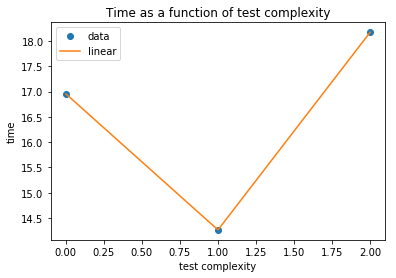

In [130]:
x = np.arange(0, 3, 1)
y = [np.mean(compl_light_arr), np.mean(compl_medium_arr), np.mean(compl_hard_arr)]
f1 = interp1d(x, y)

f = plt.figure(figsize=(6,4))
xnew = np.linspace(0.001, 2, num=41, endpoint=True)
plt.title('Time as a function of test complexity')
plt.xlabel('test complexity')
plt.ylabel('time')
plt.plot(x, y, 'o', xnew, f1(xnew), '-')
plt.legend(['data', 'linear'], loc='best')
plt.show()

Text(0,0.5,'time')

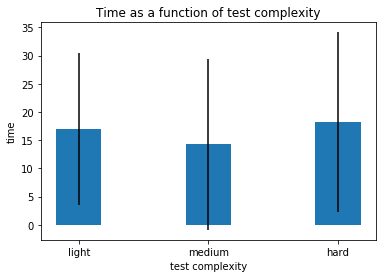

In [131]:
N = 3
ind = np.arange(N)
width = 0.35
std_arr = [np.std(compl_light_arr), np.std(compl_medium_arr), np.std(compl_hard_arr)]
plt.bar(ind, y, width, yerr=std_arr)
plt.xticks(ind, ('light', 'medium', 'hard'))
plt.title('Time as a function of test complexity')
plt.xlabel('test complexity')
plt.ylabel('time')

In [132]:
compl_light_arr = []
compl_medium_arr = []
compl_hard_arr = []

tau = 0.07
gamma = 1.

for i in range(len(data)):
    init_inf = [data.loc[i][0], data.loc[i][1], data.loc[i][2]]
    answer = data.loc[i][3]
    if data.loc[i]['Complexity'] == 0:
        tmp = []
        for j in range(100):
            tmp.append(get_time_answer(G, tau, gamma, init_inf, answer))
        compl_light_arr.append(np.mean(tmp))
    elif data.loc[i]['Complexity'] == 1:
        tmp = []
        for j in range(100):
            tmp.append(get_time_answer(G, tau, gamma, init_inf, answer))
        compl_medium_arr.append(np.mean(tmp))
    elif data.loc[i]['Complexity'] == 2:
        tmp = []
        for j in range(100):
            tmp.append(get_time_answer(G, tau, gamma, init_inf, answer))
        compl_hard_arr.append(np.mean(tmp))
            
print("Light: ", np.mean(compl_light_arr))
print("Medium: ", np.mean(compl_medium_arr))
print("Hard: ", np.mean(compl_hard_arr))

Light:  81.48241379310342
Medium:  79.74106382978722
Hard:  85.27125


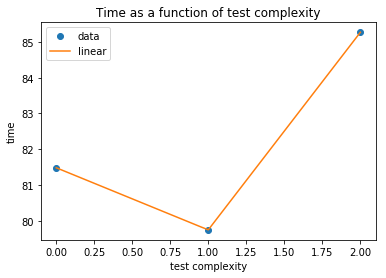

In [133]:
x = np.arange(0, 3, 1)
y = [np.mean(compl_light_arr), np.mean(compl_medium_arr), np.mean(compl_hard_arr)]
f1 = interp1d(x, y)

f = plt.figure(figsize=(6,4))
xnew = np.linspace(0.001, 2, num=41, endpoint=True)
plt.title('Time as a function of test complexity')
plt.xlabel('test complexity')
plt.ylabel('time')
plt.plot(x, y, 'o', xnew, f1(xnew), '-')
plt.legend(['data', 'linear'], loc='best')
plt.show()

Text(0,0.5,'time')

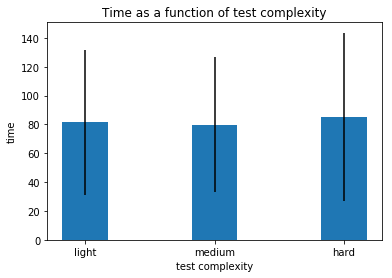

In [134]:
N = 3
ind = np.arange(N)
width = 0.35
std_arr = [np.std(compl_light_arr), np.std(compl_medium_arr), np.std(compl_hard_arr)]
plt.bar(ind, y, width, yerr=std_arr)
plt.xticks(ind, ('light', 'medium', 'hard'))
plt.title('Time as a function of test complexity')
plt.xlabel('test complexity')
plt.ylabel('time')

In [123]:
compl_light_arr = []
compl_medium_arr = []
compl_hard_arr = []

tau = 0.05
gamma = 1.

for i in range(len(data)):
    init_inf = [data.loc[i][0], data.loc[i][1], data.loc[i][2]]
    answer = data.loc[i][3]
    print(init_inf)
    if data.loc[i]['Complexity'] == 0:
        tmp = []
        for j in range(100):
            tmp.append(get_time_answer(G, tau, gamma, init_inf, answer))
        compl_light_arr.append(np.mean(tmp))
    elif data.loc[i]['Complexity'] == 1:
        tmp = []
        for j in range(100):
            tmp.append(get_time_answer(G, tau, gamma, init_inf, answer))
        compl_medium_arr.append(np.mean(tmp))
    elif data.loc[i]['Complexity'] == 2:
        tmp = []
        for j in range(100):
            tmp.append(get_time_answer(G, tau, gamma, init_inf, answer))
        compl_hard_arr.append(np.mean(tmp))
            
print("Light: ", np.mean(compl_light_arr))
print("Medium: ", np.mean(compl_medium_arr))
print("Hard: ", np.mean(compl_hard_arr))

['COTTAGE', 'SWISS', 'CAKE']
['CREAM', 'SKATE', 'WATER']
['LOSER', 'THROAT', 'SPOT']
['SHOW', 'LIFE', 'ROW']
['NIGHT', 'WRIST', 'STOP']
['DUCK', 'FOLD', 'DOLLAR']
['DEW', 'COMB', 'BEE']
['AID', 'RUBBER', 'WAGON']
['CRACKER', 'FLY', 'FIGHTER']
['SAFETY', 'CUSHION', 'POINT']
['DREAM', 'BREAK', 'LIGHT']
['FISH', 'MINE', 'RUSH']
['MEASURE', 'WORM', 'VIDEO']
['WORM', 'SHELF', 'END']
['FLOWER', 'FRIEND', 'SCOUT']
['RIVER', 'NOTE', 'ACCOUNT']
['PRINT', 'BERRY', 'BIRD']
['PIE', 'LUCK', 'BELLY']
['DATE', 'ALLEY', 'FOLD']
['OPERA', 'HAND', 'DISH']
['FUR', 'RACK', 'TAIL']
['STICK', 'MAKER', 'POINT']
['HOUND', 'PRESSURE', 'SHOT']
['DUST', 'CEREAL', 'FISH']
['LIGHT', 'BIRTHDAY', 'STICK']
['FOOD', 'FORWARD', 'BREAK']
['PEACH', 'ARM', 'TAR']
['PALM', 'SHOE', 'HOUSE']
['BASKET', 'EIGHT', 'SNOW']
['WHEEL', 'HAND', 'SHOPPING']
['RIGHT', 'CAT', 'CARBON']
['HOME', 'SEA', 'BED']
['NUCLEAR', 'FEUD', 'ALBUM']
['SANDWICH', 'HOUSE', 'GOLF']
['CROSS', 'RAIN', 'TIE']
['SAGE', 'PAINT', 'HAIR']
['FRENCH', 'CAR', '

In [139]:
tau_arr = np.linspace(0.002, 0.12, 5)
light, medium, hard = [], [], []
for tau in tau_arr:
    compl_light_arr = []
    compl_medium_arr = []
    compl_hard_arr = []
    
    gamma = 1.
    
    for i in range(len(data)):
        init_inf = [data.loc[i][0], data.loc[i][1], data.loc[i][2]]
        answer = data.loc[i][3]
        if data.loc[i]['Complexity'] == 0:
            tmp = []
            for j in range(100):
                tmp.append(get_time_answer(G, tau, gamma, init_inf, answer))
            compl_light_arr.append(np.mean(tmp))
        elif data.loc[i]['Complexity'] == 1:
            tmp = []
            for j in range(100):
                tmp.append(get_time_answer(G, tau, gamma, init_inf, answer))
            compl_medium_arr.append(np.mean(tmp))
        elif data.loc[i]['Complexity'] == 2:
            tmp = []
            for j in range(100):
                tmp.append(get_time_answer(G, tau, gamma, init_inf, answer))
            compl_hard_arr.append(np.mean(tmp))
                
    print("Light: ", np.mean(compl_light_arr))
    print("Medium: ", np.mean(compl_medium_arr))
    print("Hard: ", np.mean(compl_hard_arr))
    print('----------------------------')
    
    light.append(compl_light_arr)
    medium.append(compl_medium_arr)
    hard.append(compl_hard_arr)

Light:  0.003793103448275862
Medium:  0.004893617021276596
Hard:  0.002
----------------------------
Light:  0.2906896551724138
Medium:  0.2127659574468085
Hard:  0.12774999999999997
----------------------------
Light:  24.05275862068966
Medium:  17.94446808510638
Hard:  21.9585
----------------------------
Light:  193.4358620689655
Medium:  201.27148936170212
Hard:  191.5815
----------------------------
Light:  268.9093103448276
Medium:  262.1821276595745
Hard:  255.946
----------------------------


In [142]:
mean_light = [np.mean(arr) for arr in light]
mean_medium = [np.mean(arr) for arr in medium]
mean_hard = [np.mean(arr) for arr in hard]

In [147]:
a = np.stack([mean_light, mean_medium, mean_hard], axis = 0)
a

array([[3.79310345e-03, 2.90689655e-01, 2.40527586e+01, 1.93435862e+02,
        2.68909310e+02],
       [4.89361702e-03, 2.12765957e-01, 1.79444681e+01, 2.01271489e+02,
        2.62182128e+02],
       [2.00000000e-03, 1.27750000e-01, 2.19585000e+01, 1.91581500e+02,
        2.55946000e+02]])

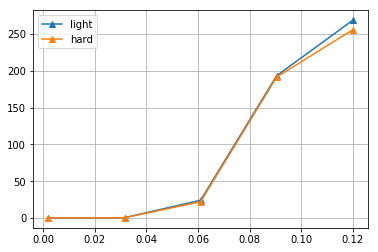

In [159]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(tau_arr, a[0], label='light', marker='^')

#ax.plot(tau_arr, a[1], label='medium', marker='^')

ax.plot(tau_arr, a[2], label='hard', marker='^')

ax.legend(loc='best')
plt.grid(True)
#ax.set_title('Number of infected as a function of time (with y log scale)')
#ax.set_xlabel('Time')
#ax.set_ylabel('Infectives')
plt.show()

In [167]:
tau_arr = np.linspace(0.002, 0.12, 5)
#tau_arr = [0.05]
light, medium, hard = [], [], []
for tau in tau_arr:
    compl_light_arr = []
    compl_medium_arr = []
    compl_hard_arr = []
    
    gamma = 1.
    
    for i in range(len(data)):
        init_inf = [data.loc[i][0], data.loc[i][1], data.loc[i][2]]
        answer = data.loc[i][3]
        if data.loc[i]['Complexity'] == 0:
            tmp = []
            for j in range(100):
                t = get_time_answer(G, tau, gamma, init_inf, answer)
                if t != 0:
                    tmp.append(t)
            if tmp:
                compl_light_arr.append(np.mean(tmp))
        elif data.loc[i]['Complexity'] == 1:
            tmp = []
            for j in range(100):
                t = get_time_answer(G, tau, gamma, init_inf, answer)
                if t != 0:
                    tmp.append(t)
            if tmp:
                compl_medium_arr.append(np.mean(tmp))
        elif data.loc[i]['Complexity'] == 2:
            tmp = []
            for j in range(100):
                t = get_time_answer(G, tau, gamma, init_inf, answer)
                if t != 0:
                    tmp.append(t)
            if tmp:
                compl_hard_arr.append(np.mean(tmp))
                
    print("Light: ", np.mean(compl_light_arr))
    print("Medium: ", np.mean(compl_medium_arr))
    print("Hard: ", np.mean(compl_hard_arr))
    print('----------------------------')
    
    light.append(compl_light_arr)
    medium.append(compl_medium_arr)
    hard.append(compl_hard_arr)

Light:  1.6666666666666667
Medium:  2.1818181818181817
Hard:  2.25
----------------------------
Light:  5.153017316017315
Medium:  4.67868777056277
Hard:  9.87987012987013
----------------------------
Light:  142.53497419365996
Medium:  153.47629671964887
Hard:  368.30938201924835
----------------------------
Light:  508.3057036901603
Medium:  542.8094967272921
Hard:  690.1031881994971
----------------------------
Light:  477.792883825832
Medium:  531.9496427933858
Hard:  683.1494672311723
----------------------------


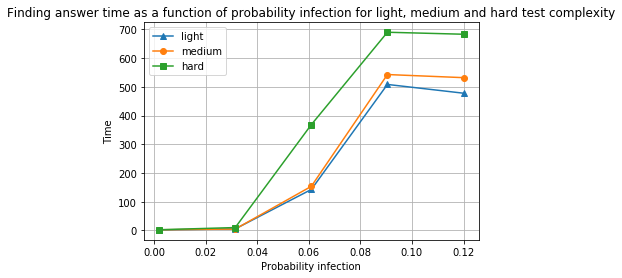

In [172]:
mean_light = [np.mean(arr) for arr in light]
mean_medium = [np.mean(arr) for arr in medium]
mean_hard = [np.mean(arr) for arr in hard]
a = np.stack([mean_light, mean_medium, mean_hard], axis = 0)

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(tau_arr, a[0], label='light', marker='^')

ax.plot(tau_arr, a[1], label='medium', marker='o')

ax.plot(tau_arr, a[2], label='hard', marker='s')

ax.legend(loc='best')
plt.grid(True)
ax.set_title('Finding answer time as a function of probability infection for light, medium and hard test complexity')
ax.set_xlabel('Probability infection')
ax.set_ylabel('Time')
plt.show()

In [174]:
tau_arr = np.linspace(0.02, 0.15, 10)
#tau_arr = [0.05]
light, medium, hard = [], [], []
light_frac, medium_frac, hard_frac = [], [], []
for tau in tau_arr:
    compl_light_arr = []
    compl_medium_arr = []
    compl_hard_arr = []
    
    light_frac_arr, medium_frac_arr, hard_frac_arr = [], [], []
    
    gamma = 1.
    
    for i in range(len(data)):
        init_inf = [data.loc[i][0], data.loc[i][1], data.loc[i][2]]
        answer = data.loc[i][3]
        if data.loc[i]['Complexity'] == 0:
            tmp = []
            for j in range(100):
                t = get_time_answer(G, tau, gamma, init_inf, answer)
                if t != 0:
                    tmp.append(t)
                    light_frac_arr.append(1)
                else:
                    light_frac_arr.append(0)
            if tmp:
                compl_light_arr.append(np.mean(tmp))
        elif data.loc[i]['Complexity'] == 1:
            tmp = []
            for j in range(100):
                t = get_time_answer(G, tau, gamma, init_inf, answer)
                if t != 0:
                    tmp.append(t)
                    medium_frac_arr.append(1)
                else:
                    medium_frac_arr.append(0)                    
            if tmp:
                compl_medium_arr.append(np.mean(tmp))
        elif data.loc[i]['Complexity'] == 2:
            tmp = []
            for j in range(100):
                t = get_time_answer(G, tau, gamma, init_inf, answer)
                if t != 0:
                    tmp.append(t)
                    hard_frac_arr.append(1)
                else:
                    hard_frac_arr.append(0)
            if tmp:
                compl_hard_arr.append(np.mean(tmp))
                
        light_frac.append(light_frac_arr)
        medium_frac.append(medium_frac_arr)
        hard_frac.append(hard_frac_arr)
                
    print("Light: ", np.mean(compl_light_arr))
    print("Medium: ", np.mean(compl_medium_arr))
    print("Hard: ", np.mean(compl_hard_arr))
    print('----------------------------')
    
    light.append(compl_light_arr)
    medium.append(compl_medium_arr)
    hard.append(compl_hard_arr)

Light:  3.3562499999999997
Medium:  3.540918367346939
Hard:  3.258399470899471
----------------------------
Light:  4.75274025974026
Medium:  7.410835275835277
Hard:  10.482401656314698
----------------------------
Light:  26.006170341556818
Medium:  24.992928072373253
Hard:  56.25708848847794
----------------------------


KeyboardInterrupt: 

## Degree distribution

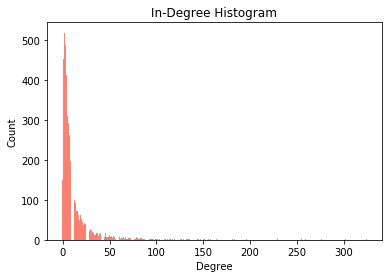

In [10]:
degree_sequence = sorted([d for n, d in G.in_degree()], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='salmon')
plt.title("In-Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")

plt.show()

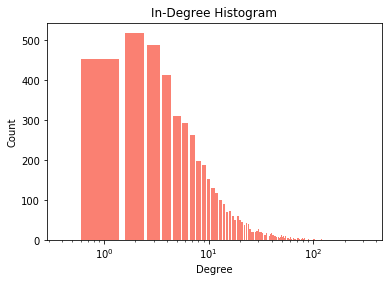

In [14]:
degree_sequence = sorted([d for n, d in G.in_degree()], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='salmon')
plt.title("In-Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
#plt.yscale('log')
plt.xscale('log')
plt.show()

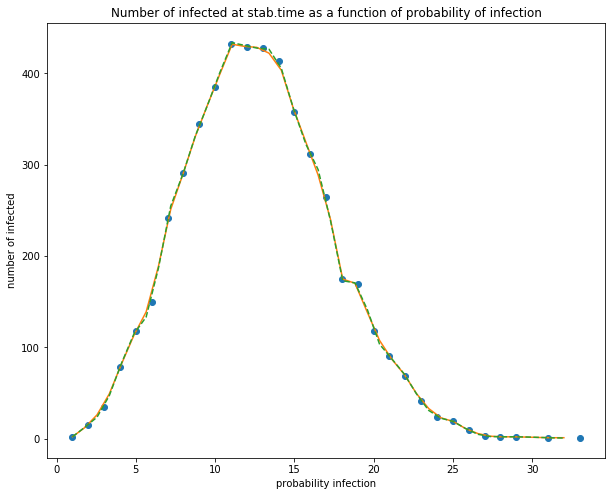

In [555]:
f1 = interp1d(deg, cnt)
f2 = interp1d(deg, cnt, kind='cubic')

f = plt.figure(figsize=(10,8))
xnew = np.linspace(1, 32, num=41, endpoint=True)
plt.title('Number of infected at stab.time as a function of probability of infection')
plt.xlabel('probability infection')
plt.ylabel('number of infected')
plt.plot(deg, cnt, 'o', xnew, f1(xnew), '-', xnew, f2(xnew), '--')

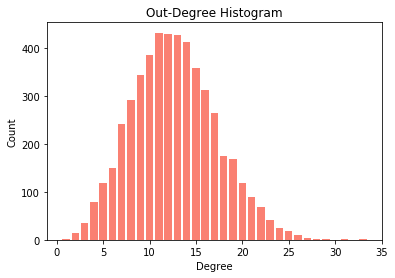

In [517]:
degree_sequence = sorted([d for n, d in G.out_degree()], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='salmon')
plt.title("Out-Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")

plt.show()

In [622]:
hubs, authorities = nx.hits(G)

In [540]:
import operator
sorted_auth = sorted(authorities.items(), key=operator.itemgetter(1))
sorted_hubs = sorted(hubs.items(), key=operator.itemgetter(1))

In [539]:
sorted_auth[-10:]

[('HOUSE', 0.0035003368981348856),
 ('LOVE', 0.003772069046420138),
 ('SCHOOL', 0.00394409715023427),
 ('WORK', 0.004435464849468816),
 ('CAR', 0.004887643477926183),
 ('WATER', 0.005436030245727071),
 ('BAD', 0.00553155445836598),
 ('GOOD', 0.006502612532462899),
 ('MONEY', 0.006625806131472505),
 ('FOOD', 0.007555279500930575)]

In [542]:
sorted_hubs[-10:]

[('PARTY', 0.0005868527959746973),
 ('NATURAL', 0.0005904593208664065),
 ('CLASS', 0.0006055791324815455),
 ('UNPLEASANT', 0.0006075014150150618),
 ('EXPENSE', 0.000613087791063398),
 ('RAPE', 0.0006265983624206124),
 ('HEALTH', 0.0006270201517289961),
 ('FRESH', 0.0006671554103756047),
 ('FAMILY', 0.0006831174068507114),
 ('MEDICINE', 0.000765471068146315)]

#### Проверим какие слова остаются активными в конце

In [750]:
tau_arr = np.linspace(0.001, 1, 10)
tau_arr

array([0.001, 0.112, 0.223, 0.334, 0.445, 0.556, 0.667, 0.778, 0.889,
       1.   ])

In [751]:
initial_size = 100
gamma = 1.
tau = 0.004
init_inf = random.sample(set(G.nodes), initial_size)
I_arr, t_arr, inf_arr = [], [], []
for tau in tau_arr:
    print("--------")
    print("infection probability: ", tau)
    #sub_i, sub_t, sub_inf = [], [], []
    #for i in range(100):
    t, S, I, inf = SIS_with_infected(G, tau, gamma, tmax = 30, initial_infecteds = init_inf)
    
    #    sub_inf.append(inf)
        
    #bug-fix
    #ens_inf = np.stack((sub_inf), axis=-1)
    #inf_arr.append(ens_inf)
    inf_arr.append(inf)

--------
infection probability:  0.001
--------
infection probability:  0.112
--------
infection probability:  0.223
--------
infection probability:  0.334
--------
infection probability:  0.445
--------
infection probability:  0.556
--------
infection probability:  0.667
--------
infection probability:  0.778
--------
infection probability:  0.889
--------
infection probability:  1.0


In [752]:
#на вход подается массив из списков зараженных для разных вероятностей заражения
#вычисляем среднюю степень принадлежности к хабу на каждом шаге
hub_degree_arr = []
for prob in range(len(inf_arr)):
    mean_hub_arr = []
    for i in range(len(inf_arr[prob])):
        mean_hub_values = []
        for j in range(len(inf_arr[prob][i])):
            mean_hub_values.append(hubs[inf_arr[prob][i][j]])
        if mean_hub_values: #берем среднее не пустых списков
            mean_hub_arr.append(np.mean(mean_hub_values))
    hub_degree_arr.append(mean_hub_arr)

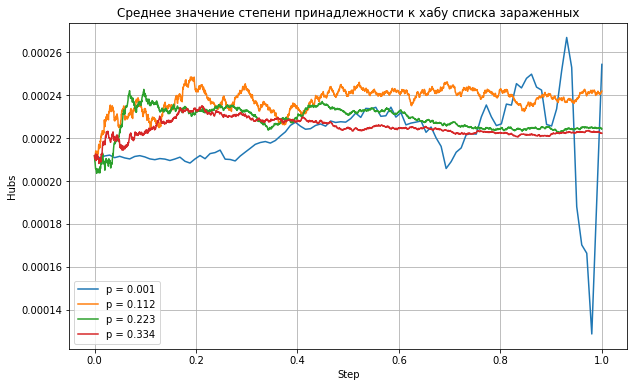

In [753]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(np.linspace(0, 1, len(hub_degree_arr[0])), hub_degree_arr[0], label='p = ' + str(round(tau_arr[0], 3)))

ax.plot(np.linspace(0, 1, len(hub_degree_arr[1])), hub_degree_arr[1], label='p = ' + str(round(tau_arr[1], 3)))

ax.plot(np.linspace(0, 1, len(hub_degree_arr[2])), hub_degree_arr[2], label='p = ' + str(round(tau_arr[2], 3)))

ax.plot(np.linspace(0, 1, len(hub_degree_arr[3])), hub_degree_arr[3], label='p = ' + str(round(tau_arr[3], 3)))

ax.legend(loc='best')
ax.grid(True)
ax.set_title('Среднее значение степени принадлежности к хабу списка зараженных')
ax.set_ylabel('Hubs')
ax.set_xlabel('Step')
plt.show()

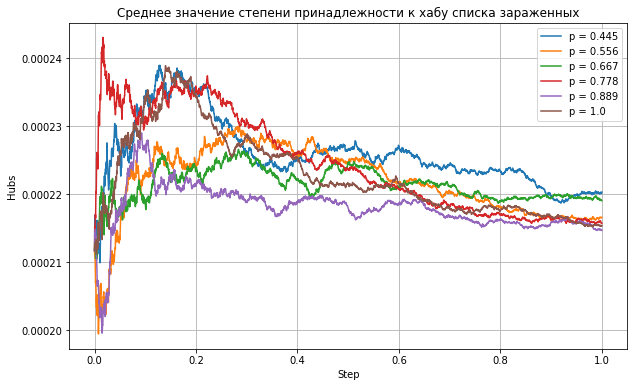

In [754]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(np.linspace(0, 1, len(hub_degree_arr[4])), hub_degree_arr[4], label='p = ' + str(round(tau_arr[4], 3)))

ax.plot(np.linspace(0, 1, len(hub_degree_arr[5])), hub_degree_arr[5], label='p = ' + str(round(tau_arr[5], 3)))

ax.plot(np.linspace(0, 1, len(hub_degree_arr[6])), hub_degree_arr[6], label='p = ' + str(round(tau_arr[6], 3)))

ax.plot(np.linspace(0, 1, len(hub_degree_arr[7])), hub_degree_arr[7], label='p = ' + str(round(tau_arr[7], 3)))

ax.plot(np.linspace(0, 1, len(hub_degree_arr[8])), hub_degree_arr[8], label='p = ' + str(round(tau_arr[8], 3)))

ax.plot(np.linspace(0, 1, len(hub_degree_arr[9])), hub_degree_arr[9], label='p = ' + str(round(tau_arr[9], 3)))

ax.legend(loc='best')
ax.grid(True)
ax.set_title('Среднее значение степени принадлежности к хабу списка зараженных')
ax.set_ylabel('Hubs')
ax.set_xlabel('Step')
plt.show()

In [755]:
#на вход подается массив из списков зараженных для разных вероятностей заражения
#вычисляем среднюю степень принадлежности к хабу на каждом шаге
auth_degree_arr = []
for prob in range(len(inf_arr)):
    mean_auth_arr = []
    for i in range(len(inf_arr[prob])):
        mean_auth_values = []
        for j in range(len(inf_arr[prob][i])):
            mean_auth_values.append(authorities[inf_arr[prob][i][j]])
        if mean_auth_values: #берем среднее не пустых списков
            mean_auth_arr.append(np.mean(mean_auth_values))
    auth_degree_arr.append(mean_auth_arr)

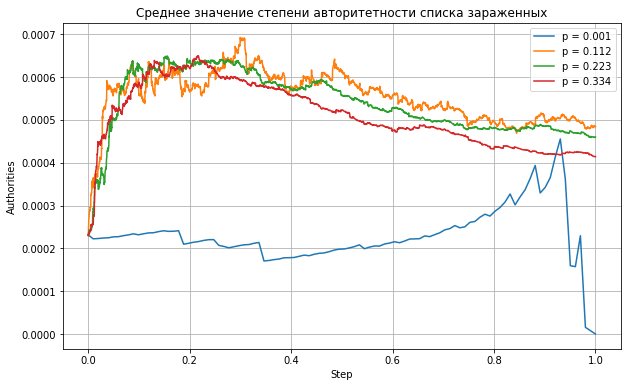

In [756]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(np.linspace(0, 1, len(auth_degree_arr[0])), auth_degree_arr[0], label='p = ' + str(round(tau_arr[0], 3)))

ax.plot(np.linspace(0, 1, len(auth_degree_arr[1])), auth_degree_arr[1], label='p = ' + str(round(tau_arr[1], 3)))

ax.plot(np.linspace(0, 1, len(auth_degree_arr[2])), auth_degree_arr[2], label='p = ' + str(round(tau_arr[2], 3)))

ax.plot(np.linspace(0, 1, len(auth_degree_arr[3])), auth_degree_arr[3], label='p = ' + str(round(tau_arr[3], 3)))

ax.legend(loc='best')
ax.grid(True)
ax.set_title('Среднее значение степени авторитетности списка зараженных')
ax.set_ylabel('Authorities')
ax.set_xlabel('Step')
plt.show()

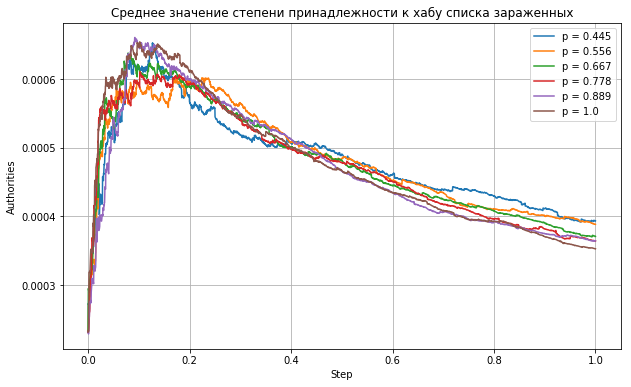

In [758]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(np.linspace(0, 1, len(auth_degree_arr[4])), auth_degree_arr[4], label='p = ' + str(round(tau_arr[4], 3)))

ax.plot(np.linspace(0, 1, len(auth_degree_arr[5])), auth_degree_arr[5], label='p = ' + str(round(tau_arr[5], 3)))

ax.plot(np.linspace(0, 1, len(auth_degree_arr[6])), auth_degree_arr[6], label='p = ' + str(round(tau_arr[6], 3)))

ax.plot(np.linspace(0, 1, len(auth_degree_arr[7])), auth_degree_arr[7], label='p = ' + str(round(tau_arr[7], 3)))

ax.plot(np.linspace(0, 1, len(auth_degree_arr[8])), auth_degree_arr[8], label='p = ' + str(round(tau_arr[8], 3)))

ax.plot(np.linspace(0, 1, len(auth_degree_arr[9])), auth_degree_arr[9], label='p = ' + str(round(tau_arr[9], 3)))

ax.legend(loc='best')
ax.grid(True)
ax.set_title('Среднее значение степени авторитетности списка зараженных')
ax.set_ylabel('Authorities')
ax.set_xlabel('Step')
plt.show()

1. распределение по степеням (in and out - bernoili and powerlaw)
2. какие слова остаются активными в конце (степени слов, почему именно они () хабы или нет)
3. делать другие ансамбли (для определенных зараженных)
4. исследовать самые богатые по степени зараженные вершины ()
5. сделать для легких и тяжелых тестов (внутри ансамбль)
6. увеличить время и посмотреть

In [85]:
def randomization(InputGraph, steps):
    G = InputGraph.copy()
    L = list(G.edges())
    e_max = len(L) - 1
    st = 0
    while (st < steps):
        e1 = random.randint(0, e_max)
        e2 = random.randint(0, e_max) 
        (P, Q) = L[e1]
        (R, S) = L[e2] 
        if ((P!=R) and (Q!=S) and (not G.has_edge(P,R)) and (not G.has_edge(Q,S))):
            G.remove_edge(R, S)
            G.remove_edge(P, Q)
            G.add_edge(P, R)
            G.add_edge(Q, S)
            L[e1] = (P,R)
            L[e2] = (Q,S)
            st = st + 1
    return(G)

In [86]:
RG = randomization(G, 10 * G.number_of_edges())

In [ ]:
compl_light_arr = []
compl_medium_arr = []
compl_hard_arr = []

tau = 0.08
gamma = 1.

for i in range(len(data)):
    init_inf = [data.loc[i][0], data.loc[i][1], data.loc[i][2]]
    answer = data.loc[i][3]
    if data.loc[i]['Complexity'] == 0:
        tmp = []
        for j in range(100):
            tmp.append(get_time_answer(RG, tau, gamma, init_inf, answer))
        compl_light_arr.append(np.mean(tmp))
    elif data.loc[i]['Complexity'] == 1:
        tmp = []
        for j in range(100):
            tmp.append(get_time_answer(RG, tau, gamma, init_inf, answer))
        compl_medium_arr.append(np.mean(tmp))
    elif data.loc[i]['Complexity'] == 2:
        tmp = []
        for j in range(100):
            tmp.append(get_time_answer(RG, tau, gamma, init_inf, answer))
        compl_hard_arr.append(np.mean(tmp))
            
print("Light: ", np.mean(compl_light_arr))
print("Medium: ", np.mean(compl_medium_arr))
print("Hard: ", np.mean(compl_hard_arr))